<a href="https://colab.research.google.com/github/lustraka/Predict_Ames_House_Prices/blob/main/collab/Ames-Housing-EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🏘️ Ames Housing Dataset EDA
## Import Dependecies

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#from pandas.api.types import CategoricalDtype # ordered categorical data type, see encode()
import matplotlib.pyplot as plt # visualization
import seaborn as sns # visualization
from scipy import stats # statistical toolset
from scipy.stats import norm # to fit distplot(), though sns.distplot() is a deprecated function

import warnings
warnings.filterwarnings('ignore')

### Set up a data pre-processing module `ames.py`

In [2]:
%%writefile ames.py
"""Download, pre-process Ames Housing dataset."""
# Import dependencies
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas.api.types import CategoricalDtype # ordered categorical data type, see encode()

def load_data_raw():
    """Load train and test data from Kaggle.com."""

    # Download the Ames Housing Dataset
    # Set the enviroment variables
    import os
    os.environ['KAGGLE_USERNAME'] = "lubomrstraka"
    os.environ['KAGGLE_KEY'] = "c7347462ef834e6645ce238c2f2fa561"

    # Download datasets
    os.system("kaggle competitions download -c house-prices-advanced-regression-techniques --quiet")

    # Read Train & Test Baseline Data
    train_bl = pd.read_csv('train.csv', index_col='Id')
    test_bl = pd.read_csv('test.csv', index_col='Id')

    return train_bl, test_bl

# The numeric features are already encoded correctly (`float` for
# continuous, `int` for discrete), but the categoricals we'll need to
# do ourselves. Note in particular, that the `MSSubClass` feature is
# read as an `int` type, but is actually a (nominative) categorical.

# The categorical features nominative (unordered)
catn = ["MSSubClass", "MSZoning", "Street", "Alley", "LandContour", "LotConfig",
        "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle", 
        "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", 
        "Foundation", "Heating", "CentralAir", "GarageType", "MiscFeature", 
        "SaleType", "SaleCondition"]


# The categorical features ordinal (ordered) 

# Pandas calls the categories "levels"
five_levels = ["Po", "Fa", "TA", "Gd", "Ex"]
ten_levels = list(range(10))

cato = {
    "OverallQual": ten_levels,
    "OverallCond": ten_levels,
    "ExterQual": five_levels,
    "ExterCond": five_levels,
    "BsmtQual": five_levels,
    "BsmtCond": five_levels,
    "HeatingQC": five_levels,
    "KitchenQual": five_levels,
    "FireplaceQu": five_levels,
    "GarageQual": five_levels,
    "GarageCond": five_levels,
    "PoolQC": five_levels,
    "LotShape": ["Reg", "IR1", "IR2", "IR3"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "BsmtExposure": ["No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    "GarageFinish": ["Unf", "RFn", "Fin"],
    "PavedDrive": ["N", "P", "Y"],
    "Utilities": ["NoSeWa", "NoSewr", "AllPub"],
    "CentralAir": ["N", "Y"],
    "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    "Fence": ["MnWw", "GdWo", "MnPrv", "GdPrv"],
}

# Add a None level for missing values
cato = {key: ["None"] + value for key, value in
                  cato.items()}


def encode_dtypes(df):
    """Encode nominal and ordinal categorical variables."""

    global catn, cato

    # Nominal categories
    for name in catn:
        df[name] = df[name].astype("category")
        # Add a None category for missing values
        if "None" not in df[name].cat.categories:
            df[name].cat.add_categories("None", inplace=True)
    # Ordinal categories
    for name, levels in cato.items():
        df[name] = df[name].astype(CategoricalDtype(levels,
                                                    ordered=True))
    return df

def impute_missing(df):
    """Impute zeros to numerical and None to categorical variables."""

    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("category"):
        df[name] = df[name].fillna("None")
    return df

def clean_data(df):
    """Remedy typos and mistakes based on EDA."""

    global cato
    # YearRemodAdd: Remodel date (same as construction date if no remodeling or additions)
    df.YearRemodAdd = np.where(df.YearRemodAdd < df.YearBuilt, df.YearBuilt, df.YearRemodAdd)
    assert len(df.loc[df.YearRemodAdd < df.YearBuilt]) == 0, 'Check YearRemodAdd - should be greater or equal then YearBuilt'
    
    # Check range of years
    yr_max = 2022
    # Some values of GarageYrBlt are corrupt. Fix them by replacing them with the YearBuilt
    df.GarageYrBlt = np.where(df.GarageYrBlt > yr_max, df.YearBuilt, df.GarageYrBlt)
    assert df.YearBuilt.max() < yr_max and df.YearBuilt.min() > 1800, 'Check YearBuilt min() and max()'
    assert df.YearRemodAdd.max() < yr_max and df.YearRemodAdd.min() > 1900, 'Check YearRemodAdd min() and max()'
    assert df.YrSold.max() < yr_max and df.YrSold.min() > 2000, 'Check YrSold min() and max()'
    assert df.GarageYrBlt.max() < yr_max and df.GarageYrBlt.min() >= 0, 'Check GarageYrBlt min() and max()'
    
    # Check values of ordinal catagorical variables
    for k in cato.keys():
      assert set(df[k].unique()).difference(df[k].cat.categories) == set(), f'Check values of {k}'
    
    # Check typos in nominal categorical variables
    df['Exterior2nd'] = df['Exterior2nd'].replace({'Brk Cmn':'BrkComm', 'CmentBd':'CemntBd', 'Wd Shng':'WdShing'})
    # Renew a data type after replacement
    df['Exterior2nd'] = df['Exterior2nd'].astype("category")
    if "None" not in df['Exterior2nd'].cat.categories:
        df['Exterior2nd'].cat.add_categories("None", inplace=True)

    return df

def label_encode(df):
    """Encode categorical variables using their dtype setting."""

    X = df.copy()
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    return X

def load_data_clean():
    """Load and data and pre-process them."""

    train_bl, test_bl = load_data_raw()

    train = train_bl.copy()
    train = encode_dtypes(train)
    train = impute_missing(train)
    train = clean_data(train)

    test = test_bl.copy()
    test = encode_dtypes(test)
    test = impute_missing(test)
    test = clean_data(test)

    return train, test


Overwriting ames.py


## Download the Ames Housing Dataset

In [3]:
import ames
print(help(ames))

Help on module ames:

NAME
    ames - Download, pre-process Ames Housing dataset.

FUNCTIONS
    clean_data(df)
        Remedy typos and mistakes based on EDA.
    
    encode_dtypes(df)
        Encode nominal and ordinal categorical variables.
    
    impute_missing(df)
        Impute zeros to numerical and None to categorical variables.
    
    label_encode(df)
        Encode categorical variables using their dtype setting.
    
    load_data_clean()
        Load and data and pre-process them.
    
    load_data_raw()
        Load train and test data from Kaggle.com.

DATA
    catn = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LandContour', 'L...
    cato = {'BsmtCond': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], 'BsmtExpos...
    five_levels = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
    ten_levels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

FILE
    /content/ames.py


None


In [4]:
#train_bl, test_bl = ames.load_data_raw()
#print(f"train_bl.shape = {train_bl.shape}, test_bl.shape = {test_bl.shape}")

In [5]:
#pd.concat([train_bl.tail(), test_bl.head()])

## Know your data

The diagram below show key step of Exporatory Data Analysis (EDA) and feature engineering needed to prepare data for machine learning.

![EDA WorkFlow](http://www.plantuml.com/plantuml/png/ZP71Ri8m38RlUGeVjrSe4m9jEt10ceJs0AOn9I9DaErqgxI7NqX9nNhQiVb_-_lzToEAhAdtfdcBNy57jA1dWYCAUHS8B2eAwOjfzdYPFi65WO967d_CAVB5DE-XZJQBEbv9LkKHi4CNJBFhhqa9UYVYGcS6z6bfUVM40OWviXWC5c9IxuWNjWbYMbJg8hiMVJPGjjypV5zzP2hf5JjIU4h13SWEZvv0DDdnUPLzeld1oRauwHO8rSKmdxp-k-j28vm8DJ49O2ZrE0OcNyO4DDwPNA1zyZfXjLBdcYOOcVqE3ctaPH55ptAMwlg5urC8Zf6Jea5_Qq7F_MC91_BKwfmtdxiLeVvM0DPVMTDihQt6HyX_XGgTpofrLKWcVt0SdAM7SgguDfiydNh_2m00)

<!--
Apply "Decode URL" to the diagram's URL at http://www.plantuml.com/plantuml/uml/ to get the source code of the diagram if changes needed.
-->

# Exploratory Data Analysis
## Make Data Inventory

In [6]:
#train_bl.info()

### Pre-process dataset
Function `ames.load_data_clean()` takes care of input data. Steps:
+ encode dtypes 
+ impute missing values
+ clean errors and outliers
+ label-encode categorical variables

In [7]:
train, test = ames.load_data_clean()
print(f"train.shape = {train.shape}, test.shape = {test.shape}")
print(train.info())

train.shape = (1460, 80), test.shape = (1459, 79)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   MSSubClass     1460 non-null   category
 1   MSZoning       1460 non-null   category
 2   LotFrontage    1460 non-null   float64 
 3   LotArea        1460 non-null   int64   
 4   Street         1460 non-null   category
 5   Alley          1460 non-null   category
 6   LotShape       1460 non-null   category
 7   LandContour    1460 non-null   category
 8   Utilities      1460 non-null   category
 9   LotConfig      1460 non-null   category
 10  LandSlope      1460 non-null   category
 11  Neighborhood   1460 non-null   category
 12  Condition1     1460 non-null   category
 13  Condition2     1460 non-null   category
 14  BldgType       1460 non-null   category
 15  HouseStyle     1460 non-null   category
 16  OverallQual    1460 non-null

In [8]:
with open('data_description.txt', 'r') as txt:
  print(txt.read())

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

In [9]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,WdShing,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000


## Explore the Target (`SalePrice`)

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64 

Skewness (symmetry): 	1.88288
Kurtosis (flatness): 	6.53628


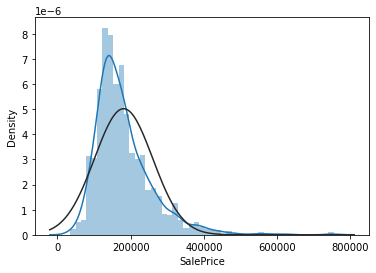

In [10]:
# Overview basic statistical properties
print(train['SalePrice'].describe(), '\n')
# print(df_train['SalePrice'].describe()) # alternatively
# Calculate skewness and kurtosis
print(f"Skewness (symmetry): \t{train['SalePrice'].skew():.5f}")
print(f"Kurtosis (flatness): \t{train['SalePrice'].kurt():.5f}")

# Draw a histogram with a normal distribution fit
sns.distplot(train['SalePrice'], fit=norm)
plt.show()

**Observations**:
+ The variable (`SalePrice`) has no missing values.
+ It deviates from the normal distribution
+ It has appreciable positive skewness (to the right).
+ It shows peakedness.

## Establish the evaluation baseline


In [11]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

def score_RMSLE(X, y, model=XGBRegressor()):
    """Use XGBRegressor to calculate RMSLE score."""

    log_y = np.log(y)
    score = cross_val_score(model, X, log_y, cv=5, scoring='neg_mean_squared_error')
    score = -1 * score.mean()
    # Metric is Root Mean Squared Log Error (RMSLE)
    score = np.sqrt(score)

    return score

In [12]:
X = train.copy()
y = X.pop('SalePrice')
X = ames.label_encode(X)
score_bl = score_RMSLE(X, y)
print(f"Baseline score : {score_bl:.5f} RMSLE.")

[08:21:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:21:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:21:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:21:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:21:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Baseline score : 0.13031 RMSLE.


## Explore the Key Features and Their Relations to the Target
+ Mutual information regression (mi_scores)
+ Correlation
+ Boruta

In [13]:
# Calculate Mutual Information Regression
from sklearn.feature_selection import mutual_info_regression
# All dicreate features should now have integer dtypes
discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
mi_scores = pd.Series(mi_scores, name='MIScores', index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)
mi_scores[:10]

OverallQual     0.575138
Neighborhood    0.532467
GarageArea      0.498154
GrLivArea       0.434649
YearBuilt       0.409232
TotalBsmtSF     0.396820
LotArea         0.393963
GarageCars      0.365115
BsmtQual        0.329060
ExterQual       0.324959
Name: MIScores, dtype: float64

In [14]:
# Compute correlation
corr_X_y = X.corrwith(y).abs().sort_values(ascending=False)
corr_X_y = pd.Series(corr_X_y, name='Correlation')
corr_X_y[:10]

GrLivArea       0.708624
ExterQual       0.682639
KitchenQual     0.659600
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
BsmtQual        0.585207
FullBath        0.560664
GarageFinish    0.549247
Name: Correlation, dtype: float64

In [15]:
# Select features by Boruta
!pip install boruta
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

In [16]:
clf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
clf.fit(X, y)

# Define Boruta feature selection method
feat_selector = BorutaPy(clf, n_estimators='auto', verbose=0, random_state=1)

# Find all relevant features
# NOTE BorutaPy accepts numpy arrays only, hence the .values attribute
feat_selector.fit(X.values, y.values)

BorutaPy(alpha=0.05,
         estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                          class_weight='balanced',
                                          criterion='gini', max_depth=5,
                                          max_features='auto',
                                          max_leaf_nodes=None, max_samples=None,
                                          min_impurity_decrease=0.0,
                                          min_impurity_split=None,
                                          min_samples_leaf=1,
                                          min_samples_split=2,
                                          min_weight_fraction_leaf=0.0,
                                          n_estimators=40, n_jobs=-1,
                                          oob_score=False,
                                          random_state=RandomState(MT19937) at 0x7F4BBD8677C0,
                                          verbose=0, warm_start=F

In [17]:
# Observation: Unforunately no feature recommended by this algorithm
feat_selector.n_features_

0

In [18]:
# Notice: no feature with rank 1
feat_selector.ranking_

array([49, 30, 13,  5, 55, 78, 35, 69, 80, 73, 69, 17, 63, 26, 72, 65, 23,
       23,  7, 16, 58, 74, 38, 35, 33,  8, 41, 31, 40, 53, 65, 43, 58, 10,
       47, 20,  4, 11, 23, 71, 75, 61,  3,  9, 42,  2, 53, 47, 32, 39, 19,
       79, 60, 15, 55, 34, 45, 58, 12, 67, 28,  6, 51, 69, 77, 13, 18, 21,
       64, 27, 49, 45, 75, 37, 23, 29, 44, 62, 52])

In [19]:
# Use features accordning to rank
boruta_rank = pd.Series(feat_selector.ranking_, index=X.columns, name='Boruta')
boruta_rank =  80 - boruta_rank # Convert rank to score
boruta_rank = boruta_rank.sort_values(ascending=False)
boruta_rank[:10]

GrLivArea      78
1stFlrSF       77
BsmtUnfSF      76
LotArea        75
GarageArea     74
YearBuilt      73
MasVnrArea     72
2ndFlrSF       71
BsmtFinSF1     70
TotalBsmtSF    69
Name: Boruta, dtype: int64

In [20]:
# Report top features for next step
top_features = pd.concat([mi_scores[:10], corr_X_y[:10], boruta_rank[:10]], axis=1)
top_features

,MIScores,Correlation,Boruta
OverallQual,0.575138,NaN,NaN
Neighborhood,0.532467,NaN,NaN
GarageArea,0.498154,0.623431,74.0
GrLivArea,0.434649,0.708624,78.0
YearBuilt,0.409232,NaN,73.0
TotalBsmtSF,0.396820,0.613581,69.0
LotArea,0.393963,NaN,75.0
GarageCars,0.365115,0.640409,NaN
BsmtQual,0.329060,0.585207,NaN
ExterQual,0.324959,0.682639,NaN


In [21]:
cols1 = ['OverallQual', 'Neighborhood', 'GarageArea', 'GrLivArea', 'YearBuilt', 'SalePrice']
cols2 = ['TotalBsmtSF', 'LotArea', 'KitchenQual', 'ExterQual', '1stFlrSF', 'BsmtQual', 'SalePrice']

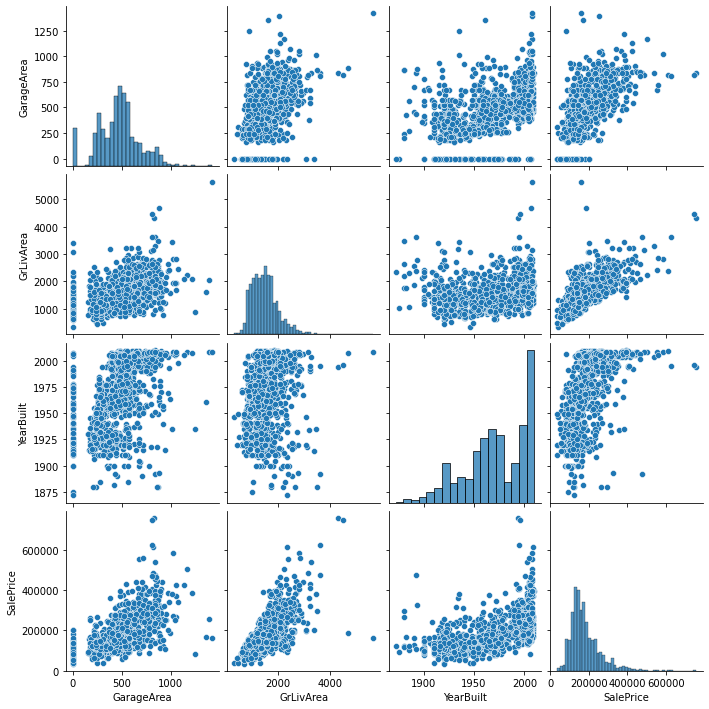

In [22]:
sns.pairplot(train[cols1])

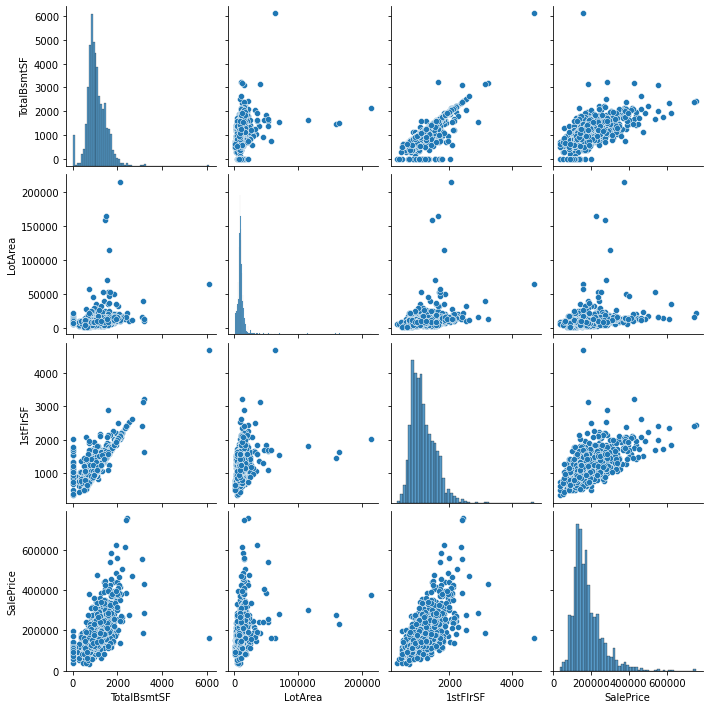

In [23]:
sns.pairplot(train[cols2])

Observation: Using only selected features doesn't improve the score.

In [24]:
# Compare feature selection with a baseline score
print(f"\nTop-Features score : {score_RMSLE(X.loc[:,top_features.index], y):.5f} RMSLE, cf. with baseline score : {score_bl:.5f} RMSLE.")

[08:23:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:23:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:23:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:23:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:23:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Top-Features score : 0.14261 RMSLE, cf. with baseline score : 0.13031 RMSLE.


## Ames Feature Engineering

In [25]:
mi_scores[mi_scores==0].index

Index(['PoolQC', 'BsmtFinSF2', 'MoSold', 'YrSold'], dtype='object')

Dropping uninformative features improve the score slightly.

In [26]:
%%writefile ames_fe.py
"""Feature engineering module for Ames Housing Dataset."""

import pandas as pd
import ames

def drop_uninformative(df):
    """Drops columns with MI Score equal to 0."""
    cols_uninformative = ['PoolQC', 'MiscVal', 'MoSold']
    df = df.drop(columns=cols_uninformative)
    return df

def mathematical_transforms(df):
    """Get a couple of feature based on mathematical formulas."""
    X = pd.DataFrame()
    X["Spaciousness"] = (df['1stFlrSF'] + df['2ndFlrSF']) / df.TotRmsAbvGrd
    X["TotalOutsideSF"] = df.WoodDeckSF + df.OpenPorchSF + df.EnclosedPorch + df['3SsnPorch'] + df.ScreenPorch
    X['OverallQC'] = df.OverallQual.cat.codes * df.OverallCond.cat.codes
    X['BsmtQSF'] = df.BsmtQual.cat.codes * df.TotalBsmtSF
    return X

def interactions(df):
    """Get one-hot encoding of garage types * garage area."""
    X = pd.get_dummies(df.GarageType, prefix="Garage")
    X = X.mul(df.GarageArea, axis=0)
    return X

def counts(df):
    """Count number of porch types."""
    X = pd.DataFrame()
    X["PorchTypes"] = df[[
        "WoodDeckSF",
        "OpenPorchSF",
        "EnclosedPorch",
        "3SsnPorch",
        "ScreenPorch",
    ]].gt(0.0).sum(axis=1)
    return X

def group_transforms(df):
    """Group Neighborhood by median of GrLivArea."""
    X = pd.DataFrame()
    X["MedNhbdArea"] = df.groupby("Neighborhood")["GrLivArea"].transform("median")
    return X

def pca_inspired(df):
    """Create features inspired by Principal Component Analysis."""
    X = pd.DataFrame()
    X['AreaGRBsmt'] = df.GrLivArea + df.TotalBsmtSF
    return X

def tailor_ames(train, test=None):
    """Add features based on Exploratory Data Analysis of Ames Housing dataset."""

    df = train.copy()
    # The test set should be transformed in the same way as the train set.
    if test is not None:
      dft = test.copy()
      df = pd.concat([df, dft])
      df = ames.encode_dtypes(df) # Restore dtypes encoding

    df = drop_uninformative(df)
    
    # Transformations
    #df = df.join(mathematical_transforms(df))
    #df = df.join(interactions(df))
    #df = df.join(counts(df))
    df = df.join(group_transforms(df))

    # PCA inspired
    #df = df.join(pca_inspired(df))

    df = ames.label_encode(df)

    # Reform splits
    if test is not None:
      dft = df.loc[test.index, :]
      df.drop(test.index, inplace=True)

    if test is not None:
      return df, dft
    else:
      return df

def load_data_tailored():
    """Load data with adjusted features."""
    train, test = tailor_ames(*ames.load_data_clean())
    return train, test

Overwriting ames_fe.py


In [27]:
from ames_fe import load_data_tailored

X, X_test = load_data_tailored()
y = X.pop('SalePrice')

score_RMSLE(X, y)

[08:23:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:23:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:23:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:23:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:23:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.1259193567260686

In [28]:
rmsle_dict = {
    'Step' : ['baseline', 'drop_uninformative', 'mathematical_transforms', 'interactions',
              'counts', 'group_transforms', 'transformations without math', 'transformations with math',
              'pca_inspired', 'final without math', 'final complete'],
    'RMSLE': [score_bl, 0.13012690536915064, 0.13094722907054945, 0.1299796348500676,
              0.13000798939871983, 0.1259193567260686, 0.12666831420776703, 0.1269661775482726,
              0.1302635183183012, 0.12750543310593238, 0.12685997469172317]
}
results = pd.DataFrame(rmsle_dict)
results

,Step,RMSLE
0,baseline,0.130309
1,drop_uninformative,0.130127
2,mathematical_transforms,0.130947
3,interactions,0.129980
4,counts,0.130008
5,group_transforms,0.125919
6,transformations without math,0.126668
7,transformations with math,0.126966
8,pca_inspired,0.130264
9,final without math,0.127505


In [29]:
results.loc[results.RMSLE == results.RMSLE.min()]

,Step,RMSLE
5,group_transforms,0.125919
